# Testing the algorithms

- perform STFT and Spectrogram 
- select point cloud 
- select redpoints alongside with meta-data of the time , all this acting as a fingerprint 
- hash and store 

In [ ]:
import os 
import numpy as np 
import pyaudio 
import matplotlib.pyplot as plt

from scipy.signal import spectrogram
import librosa 
import ipywidgets as widgets
from IPython.display import display, Audio


import sounddevice as sd
import wave

In [ ]:

fs = 44100  # Sampling frequency
DURATION = 5  # Duration in seconds

# Widget for starting and stopping recording
record_button = widgets.Button(description="Record")
play_button = widgets.Button(description="Play")
status_label = widgets.Label(value="Click 'Record' to start recording.")

# Variable to store the recorded audio
recorded_audio = None

def record_audio(change):
    global recorded_audio
    status_label.value = "Recording..."
    try:
        # Record audio
        recorded_audio = sd.rec(int(DURATION * fs), samplerate=fs, channels=1, dtype='int16')
        sd.wait()  # Wait until recording is finished
        status_label.value = "Recording complete! Click 'Play' to listen."
    except Exception as e:
        status_label.value = f"Error: {str(e)}"

def play_audio(change):
    if recorded_audio is not None:
        # Play the recorded audio
        sd.play(recorded_audio, fs)
        sd.wait()  # Wait until playback is finished
    else:
        status_label.value = "No audio recorded yet. Please record first."
        print('type of audio: ', type(record_audio))

# Link buttons to their functions
record_button.on_click(record_audio)
play_button.on_click(play_audio)


# Display widgets
display(record_button, play_button, status_label)
print(type(recorded_audio))

Button(description='Record', style=ButtonStyle())

Button(description='Play', style=ButtonStyle())

Label(value="Click 'Record' to start recording.")

<class 'NoneType'>


In [13]:
print('type of recorded audio : ', type(recorded_audio))
print('shape of recorded audio :', recorded_audio.shape)

type of recorded audio :  <class 'numpy.ndarray'>
shape of recorded audio : (220500, 1)


## (Skip this) Spectrogram on a random signal

frequenceis shape :  (129,)
times shape  (14,)
Sxx shape :  (129, 14)


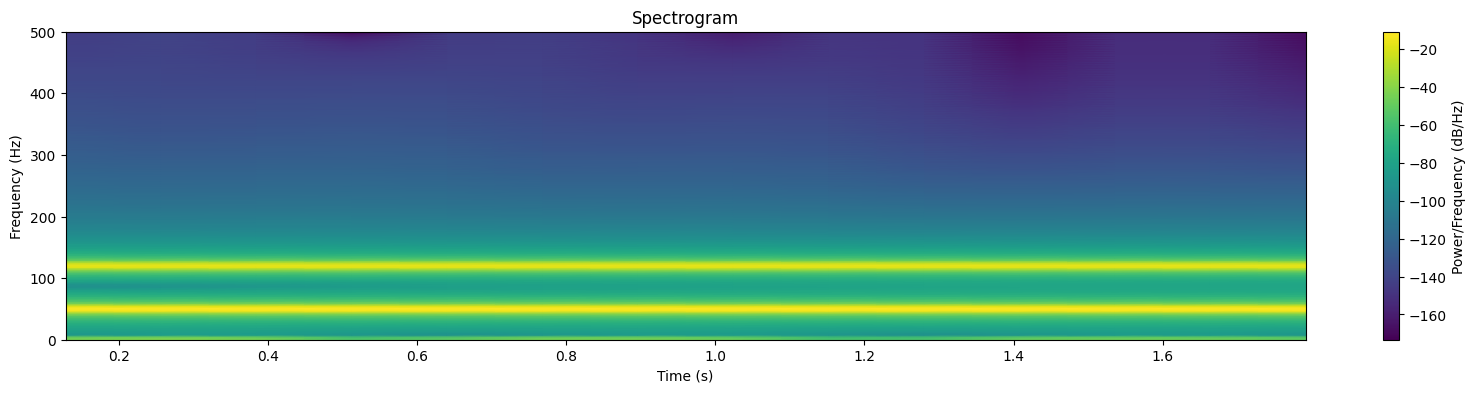

In [6]:
from scipy.signal import spectrogram

# Example signal
fs = 1000  # Sampling frequency in Hz
T = 2      # Duration in seconds
N = fs * T  # Total number of samples
t = np.linspace(0, T, N, endpoint=False)  # Time vector
x = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)  # Signal

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(x, fs, nperseg=256, noverlap=128, window='hann')

print('frequenceis shape : ', frequencies.shape)
print('times shape ', times.shape)
print('Sxx shape : ', Sxx.shape)

# Plot the spectrogram
plt.figure(figsize=(20, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')  # Convert to dB scale
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

## Spectrogram and keypoints 

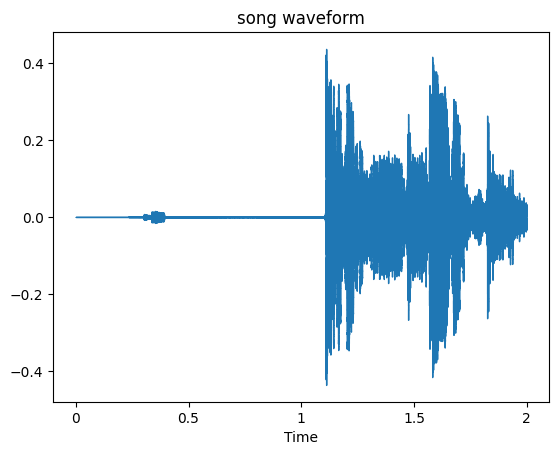

In [3]:
# reading and displaying an audio signal 

from scipy.signal import find_peaks

song_name = 'bob-sinclar-world-hold-on-official-video (1).mp3'
audio_file = os.path.join('database', song_name)

y, sr = librosa.load(audio_file)
duration = 2 * sr # 10 seconds 
begin = int(1.1 * sr)

y = y[:duration]
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y=y, sr=sr, ax=ax)
plt.title('song waveform')
plt.show()

In [4]:
# performing STFT and finding peaks 

n_fft = 2048 #  Number of samples in each FFT window. Higher values improve frequency resolution but reduce time resolution
hop_length = n_fft // 4  # 512, The number of samples between successive FFT frames. Smaller values increase overlap, providing smoother time representation.

stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)
spectrogram_dB = librosa.amplitude_to_db(spectrogram, ref=np.max)



# spectrogram : 
# each row represent a frequency bin
# each column represent a time bin  
# actual time = column index * hop_length / sampling rate (sr)
# actual frequency = row index * sr / n_fft



In [5]:
(spectrogram.shape[0]-1) * sr / n_fft

11025.0

In [6]:
# spectrogram_dB[0].shape
idx = int(1.5* hop_length / sr )
print(spectrogram_dB[:,idx])

[-80. -80. -80. ... -80. -80. -80.]


In [7]:
print(spectrogram_dB.shape)

peaks = []
for t in range(spectrogram_dB.shape[1]):  # Loop over time frames
    
    # Apply the threshold in dB, adjusting the factor if necessary
    threshold_dB = 0.5 * np.max(spectrogram_dB[:, t])  # threshold in dB
    freq_peaks, _ = find_peaks(spectrogram_dB[:, t], height=-10)  # Apply threshold to dB values

    for f in freq_peaks:
        frequency = f * sr / n_fft  # Actual frequency in Hz
        time_point = t * hop_length / sr  # Time in seconds
        peaks.append((time_point, frequency))  # Store (time_in_seconds, frequency_bin)


peaks = np.array(peaks)
print(peaks)

(1025, 87)
[[  1.11455782 150.73242188]
 [  1.13777778  43.06640625]
 [  1.13777778  75.36621094]
 [  1.13777778 107.66601562]
 [  1.13777778 139.96582031]
 [  1.16099773  53.83300781]
 [  1.16099773  86.1328125 ]
 [  1.18421769  53.83300781]
 [  1.18421769  75.36621094]
 [  1.20743764  53.83300781]
 [  1.2306576   53.83300781]
 [  1.25387755  53.83300781]
 [  1.27709751  53.83300781]
 [  1.30031746  53.83300781]
 [  1.32353741  53.83300781]
 [  1.34675737  53.83300781]
 [  1.36997732  53.83300781]
 [  1.39319728  53.83300781]
 [  1.41641723  53.83300781]
 [  1.43963719  53.83300781]
 [  1.57895692 150.73242188]
 [  1.60217687 107.66601562]
 [  1.60217687 139.96582031]
 [  1.62539683  86.1328125 ]
 [  1.64861678  53.83300781]
 [  1.64861678  75.36621094]
 [  1.67183673  53.83300781]
 [  1.67183673  75.36621094]
 [  1.69505669  64.59960938]
 [  1.71827664  53.83300781]]


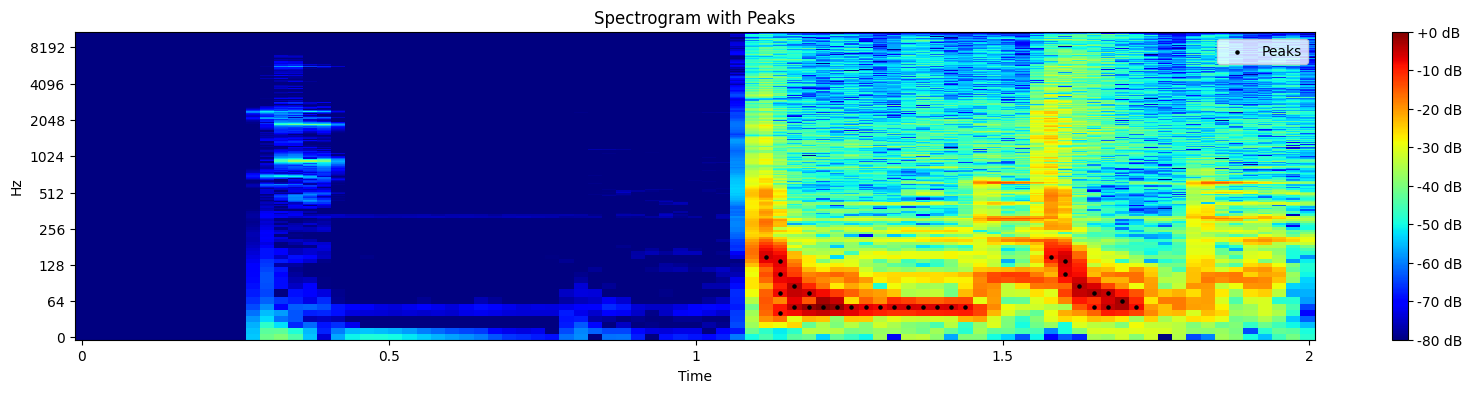

In [8]:
# Plotting
plt.figure(figsize=(20, 4))

# displaying the Spectrogram
librosa.display.specshow(spectrogram_dB, sr=sr, cmap='jet', hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')


plt.scatter(peaks[:, 0], peaks[:, 1], color='black', s=5, label='Peaks')

plt.title('Spectrogram with Peaks')
plt.legend()
plt.show()

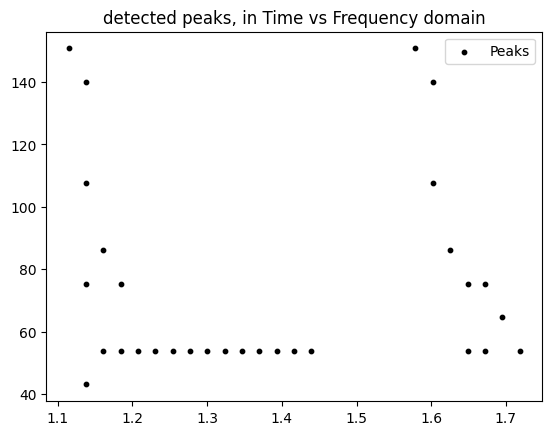

In [ ]:
plt.scatter(peaks[:, 0], peaks[:, 1], color='black', s=10, label='Peaks')

plt.title('detected peaks, in Time vs Frequency domain')
plt.legend()
plt.show()

In [9]:
# for debugging purposes 
print('sr: ', sr)
print('shape of y :', y.shape)
print('shape of spectrogram : ',spectrogram.shape)
print('spectrogram[1025,0] = ', spectrogram[1024,0])

sr:  22050
shape of y : (44100,)
shape of spectrogram :  (1025, 87)
spectrogram[1025,0] =  0.0


## Anchor points selection

In [ ]:
# splitting the spectrogram grid
# picking the max 
# 

In [11]:
# selectig anchor points and generating hashes of chains

peaks.shape

print(peaks)

[[  1.11455782 150.73242188]
 [  1.13777778  43.06640625]
 [  1.13777778  75.36621094]
 [  1.13777778 107.66601562]
 [  1.13777778 139.96582031]
 [  1.16099773  53.83300781]
 [  1.16099773  86.1328125 ]
 [  1.18421769  53.83300781]
 [  1.18421769  75.36621094]
 [  1.20743764  53.83300781]
 [  1.2306576   53.83300781]
 [  1.25387755  53.83300781]
 [  1.27709751  53.83300781]
 [  1.30031746  53.83300781]
 [  1.32353741  53.83300781]
 [  1.34675737  53.83300781]
 [  1.36997732  53.83300781]
 [  1.39319728  53.83300781]
 [  1.41641723  53.83300781]
 [  1.43963719  53.83300781]
 [  1.57895692 150.73242188]
 [  1.60217687 107.66601562]
 [  1.60217687 139.96582031]
 [  1.62539683  86.1328125 ]
 [  1.64861678  53.83300781]
 [  1.64861678  75.36621094]
 [  1.67183673  53.83300781]
 [  1.67183673  75.36621094]
 [  1.69505669  64.59960938]
 [  1.71827664  53.83300781]]


### hashing 


In [ ]:
import hashlib

def generate_hash(frequency, time, power):
    # Concatenate the frequency and time and then hash them
    hash_input = f"{frequency}-{time}".encode('utf-8')
    return hashlib.sha1(hash_input).hexdigest()

In [ ]:
# finding some peaks 
from scipy.signal import find_peaks
threshold = None
peaks, _ = find_peaks(spectrogram_dB[:,t], height=threshold)